In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# Step 1: Install the necessary libraries
!pip install datasets diffusers transformers torch torchvision tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


#Conditional Diffusion Model for Reconstructing Dark Matter Density Fields from Observed Stellar Density Field

## Hyperparameters and Data Loading/Preprocessing

In [ ]:
# Configuration settings
config = {
    "batch_size": 16,
    "epochs": 1,
    "learning_rate": 1e-4,
    "num_timesteps": 1000,
    "image_size": 64,
    "conditioning_channels": 1,
    "target_channels": 1,
    "stellar_file": '/content/drive/MyDrive/CS 163 - Dark Matter Diffusion/CAMELS CDM data/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy',
    "dm_file": '/content/drive/MyDrive/CS 163 - Dark Matter Diffusion/CAMELS CDM data/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy'
}

# Custom Dataset class to load .npy files with memory mapping
class SlicedDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.data = np.load(file_path, mmap_mode='r')  # Memory map to save memory
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        if self.transform:
            sample = self.transform(sample)
        return sample

# Define transformations
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.log10(x + 1e-8)),  # Log transformation
    transforms.Resize((config["image_size"], config["image_size"])),  # Resize to 64x64
    transforms.Lambda(lambda x: ((x - x.min()) / (x.max() - x.min()) - 0.5) * 2)  # Normalize to [-1, 1]
])

# Initialize datasets using memory-mapped SlicedDataset
stellar_dataset = SlicedDataset(file_path=config["stellar_file"], transform=transform)
dm_dataset = SlicedDataset(file_path=config["dm_file"], transform=transform)

# DataLoader for batching
stellar_dataloader = DataLoader(stellar_dataset, batch_size=config["batch_size"], shuffle=True)
dm_dataloader = DataLoader(dm_dataset, batch_size=config["batch_size"], shuffle=True)

# Initialize the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=config["num_timesteps"])

##Visualize Ground Truth Samples

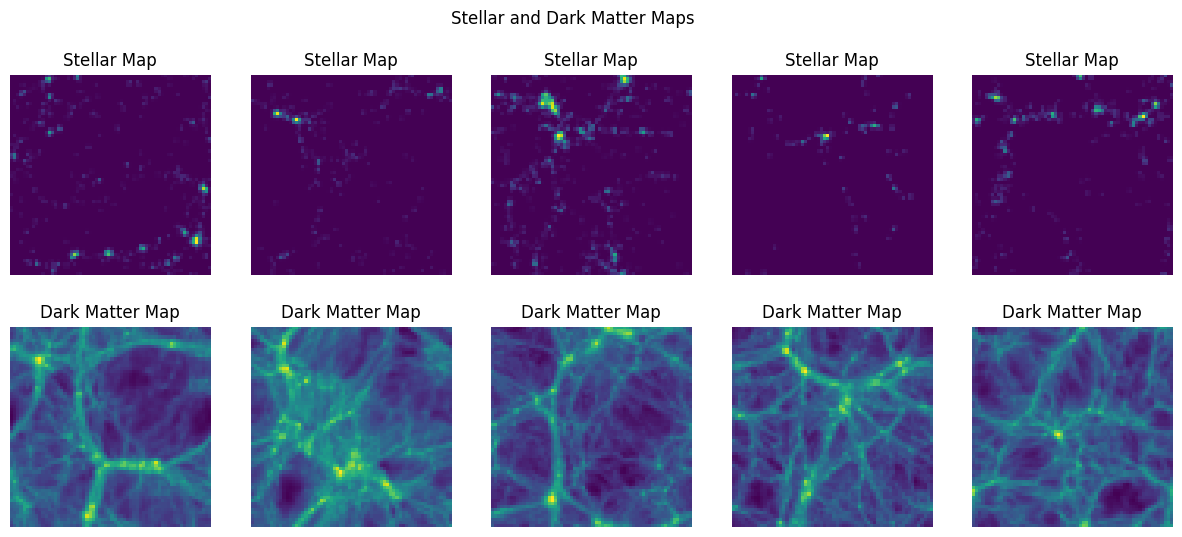

In [ ]:
# Function to visualize the maps
def visualize_maps(stellar_loader, dm_loader, num_samples=5):
    stellar_maps = next(iter(stellar_loader))
    dm_maps = next(iter(dm_loader))

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        axes[0, i].imshow(stellar_maps[i].squeeze().cpu(), cmap="viridis")
        axes[0, i].axis("off")
        axes[0, i].set_title("Stellar Map")

        axes[1, i].imshow(dm_maps[i].squeeze().cpu(), cmap="viridis")
        axes[1, i].axis("off")
        axes[1, i].set_title("Dark Matter Map")

    plt.suptitle("Stellar and Dark Matter Maps")
    plt.show()

# Visualize samples from the datasets
visualize_maps(stellar_dataloader, dm_dataloader, num_samples=5)

## Conditional UNet Model

In [ ]:
# Conditional U-Net model for diffusion
class ConditionalUNet(nn.Module):
    def __init__(self, conditioning_channels=1, target_channels=1):
        super(ConditionalUNet, self).__init__()
        self.unet = UNet2DModel(
            sample_size=config["image_size"],
            in_channels=conditioning_channels + target_channels,
            out_channels=target_channels,
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
            block_out_channels=(48, 96, 192, 384),
            layers_per_block=2,
            norm_num_groups=8,
            act_fn="silu",
            attention_head_dim=8,
            add_attention=True,
            downsample_type='resnet',
            upsample_type='resnet'
        )

    def forward(self, x, t, condition):
        condition = condition.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat((x, condition), dim=1)
        return self.unet(x, t).sample

## Conditional Model Training

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1/1, Average Loss: 0.056690


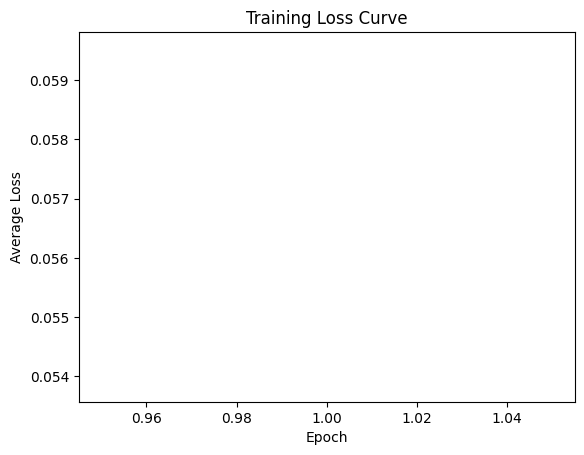

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConditionalUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

epoch_losses = []
for epoch in range(config["epochs"]):
    total_loss = 0.0
    num_batches = 0

    for stellar_maps, dm_maps in zip(stellar_dataloader, dm_dataloader):
        stellar_maps, dm_maps = stellar_maps.to(device), dm_maps.to(device)

        noise = torch.randn_like(dm_maps)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (dm_maps.shape[0],), device=device).long()

        noisy_dm = noise_scheduler.add_noise(dm_maps, noise, timesteps)

        pred_noise = model(noisy_dm, timesteps, stellar_maps)

        loss = nn.MSELoss()(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Calculate and store the average loss for this epoch
    avg_epoch_loss = total_loss / num_batches
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{config['epochs']}, Average Loss: {avg_epoch_loss:.6f}")

plt.plot(range(1, config["epochs"] + 1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.show()

##Visualize Model Output Samples

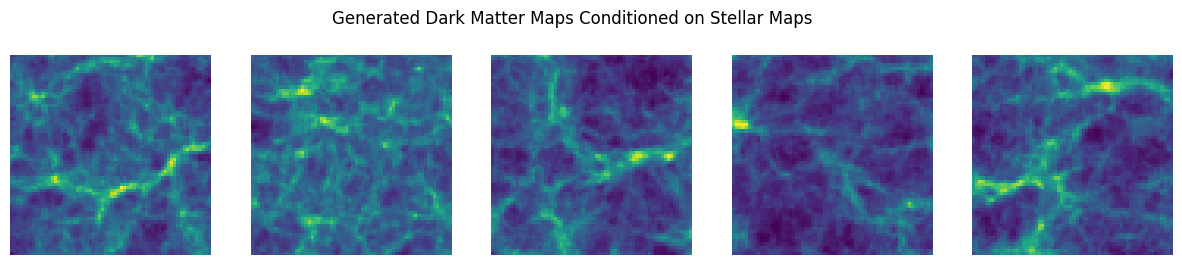

In [ ]:
def generate_dm_maps(model, stellar_maps, scheduler):
    model.eval()
    with torch.no_grad():
        num_samples = stellar_maps.size(0)
        x = torch.randn((num_samples, 1, config["image_size"], config["image_size"])).to(device)
        for t in reversed(range(scheduler.num_train_timesteps)):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            residual = model(x, timesteps, stellar_maps)
            x = scheduler.step(residual, t, x).prev_sample
    return x

sample_stellar_maps = next(iter(stellar_dataloader)).to(device)
generated_dm_maps = generate_dm_maps(model, sample_stellar_maps, noise_scheduler)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(generated_dm_maps[i].squeeze().cpu(), cmap="viridis")
    ax.axis("off")
plt.suptitle("Generated Dark Matter Maps Conditioned on Stellar Maps")
plt.show()

##Denoising Sequence of Dark Matter Maps

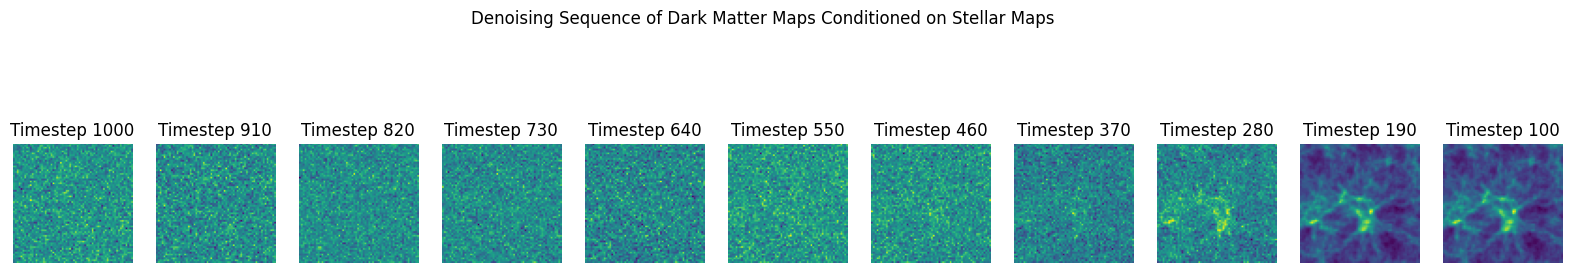

In [ ]:
# Sampling loop - Generate DM maps conditioned on stellar maps with visualization of each timestep
def generate_dm_maps_with_sequence(model, stellar_maps, noise_scheduler, num_timesteps=10):
    model.eval()
    with torch.no_grad():
        num_samples = stellar_maps.size(0)
        x = torch.randn((num_samples, 1, config["image_size"], config["image_size"])).to(device)

        denoising_sequence = []

        for t in reversed(range(noise_scheduler.num_train_timesteps)):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            residual = model(x, timesteps, stellar_maps)
            x = noise_scheduler.step(residual, t, x).prev_sample

            if t % (noise_scheduler.num_train_timesteps // num_timesteps) == 0:
                denoising_sequence.append(x.clone().cpu())

        denoising_sequence.append(x.clone().cpu())

    return denoising_sequence

sample_stellar_maps = next(iter(stellar_dataloader)).to(device)
denoising_sequence = generate_dm_maps_with_sequence(model, sample_stellar_maps, noise_scheduler, num_timesteps=10)

fig, axes = plt.subplots(1, len(denoising_sequence), figsize=(20, 4))

for i, ax in enumerate(axes):
    ax.imshow(denoising_sequence[i][0].squeeze(), cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Timestep {noise_scheduler.num_train_timesteps - i * (noise_scheduler.num_train_timesteps // len(denoising_sequence))}")

plt.suptitle("Denoising Sequence of Dark Matter Maps Conditioned on Stellar Maps")
plt.show()

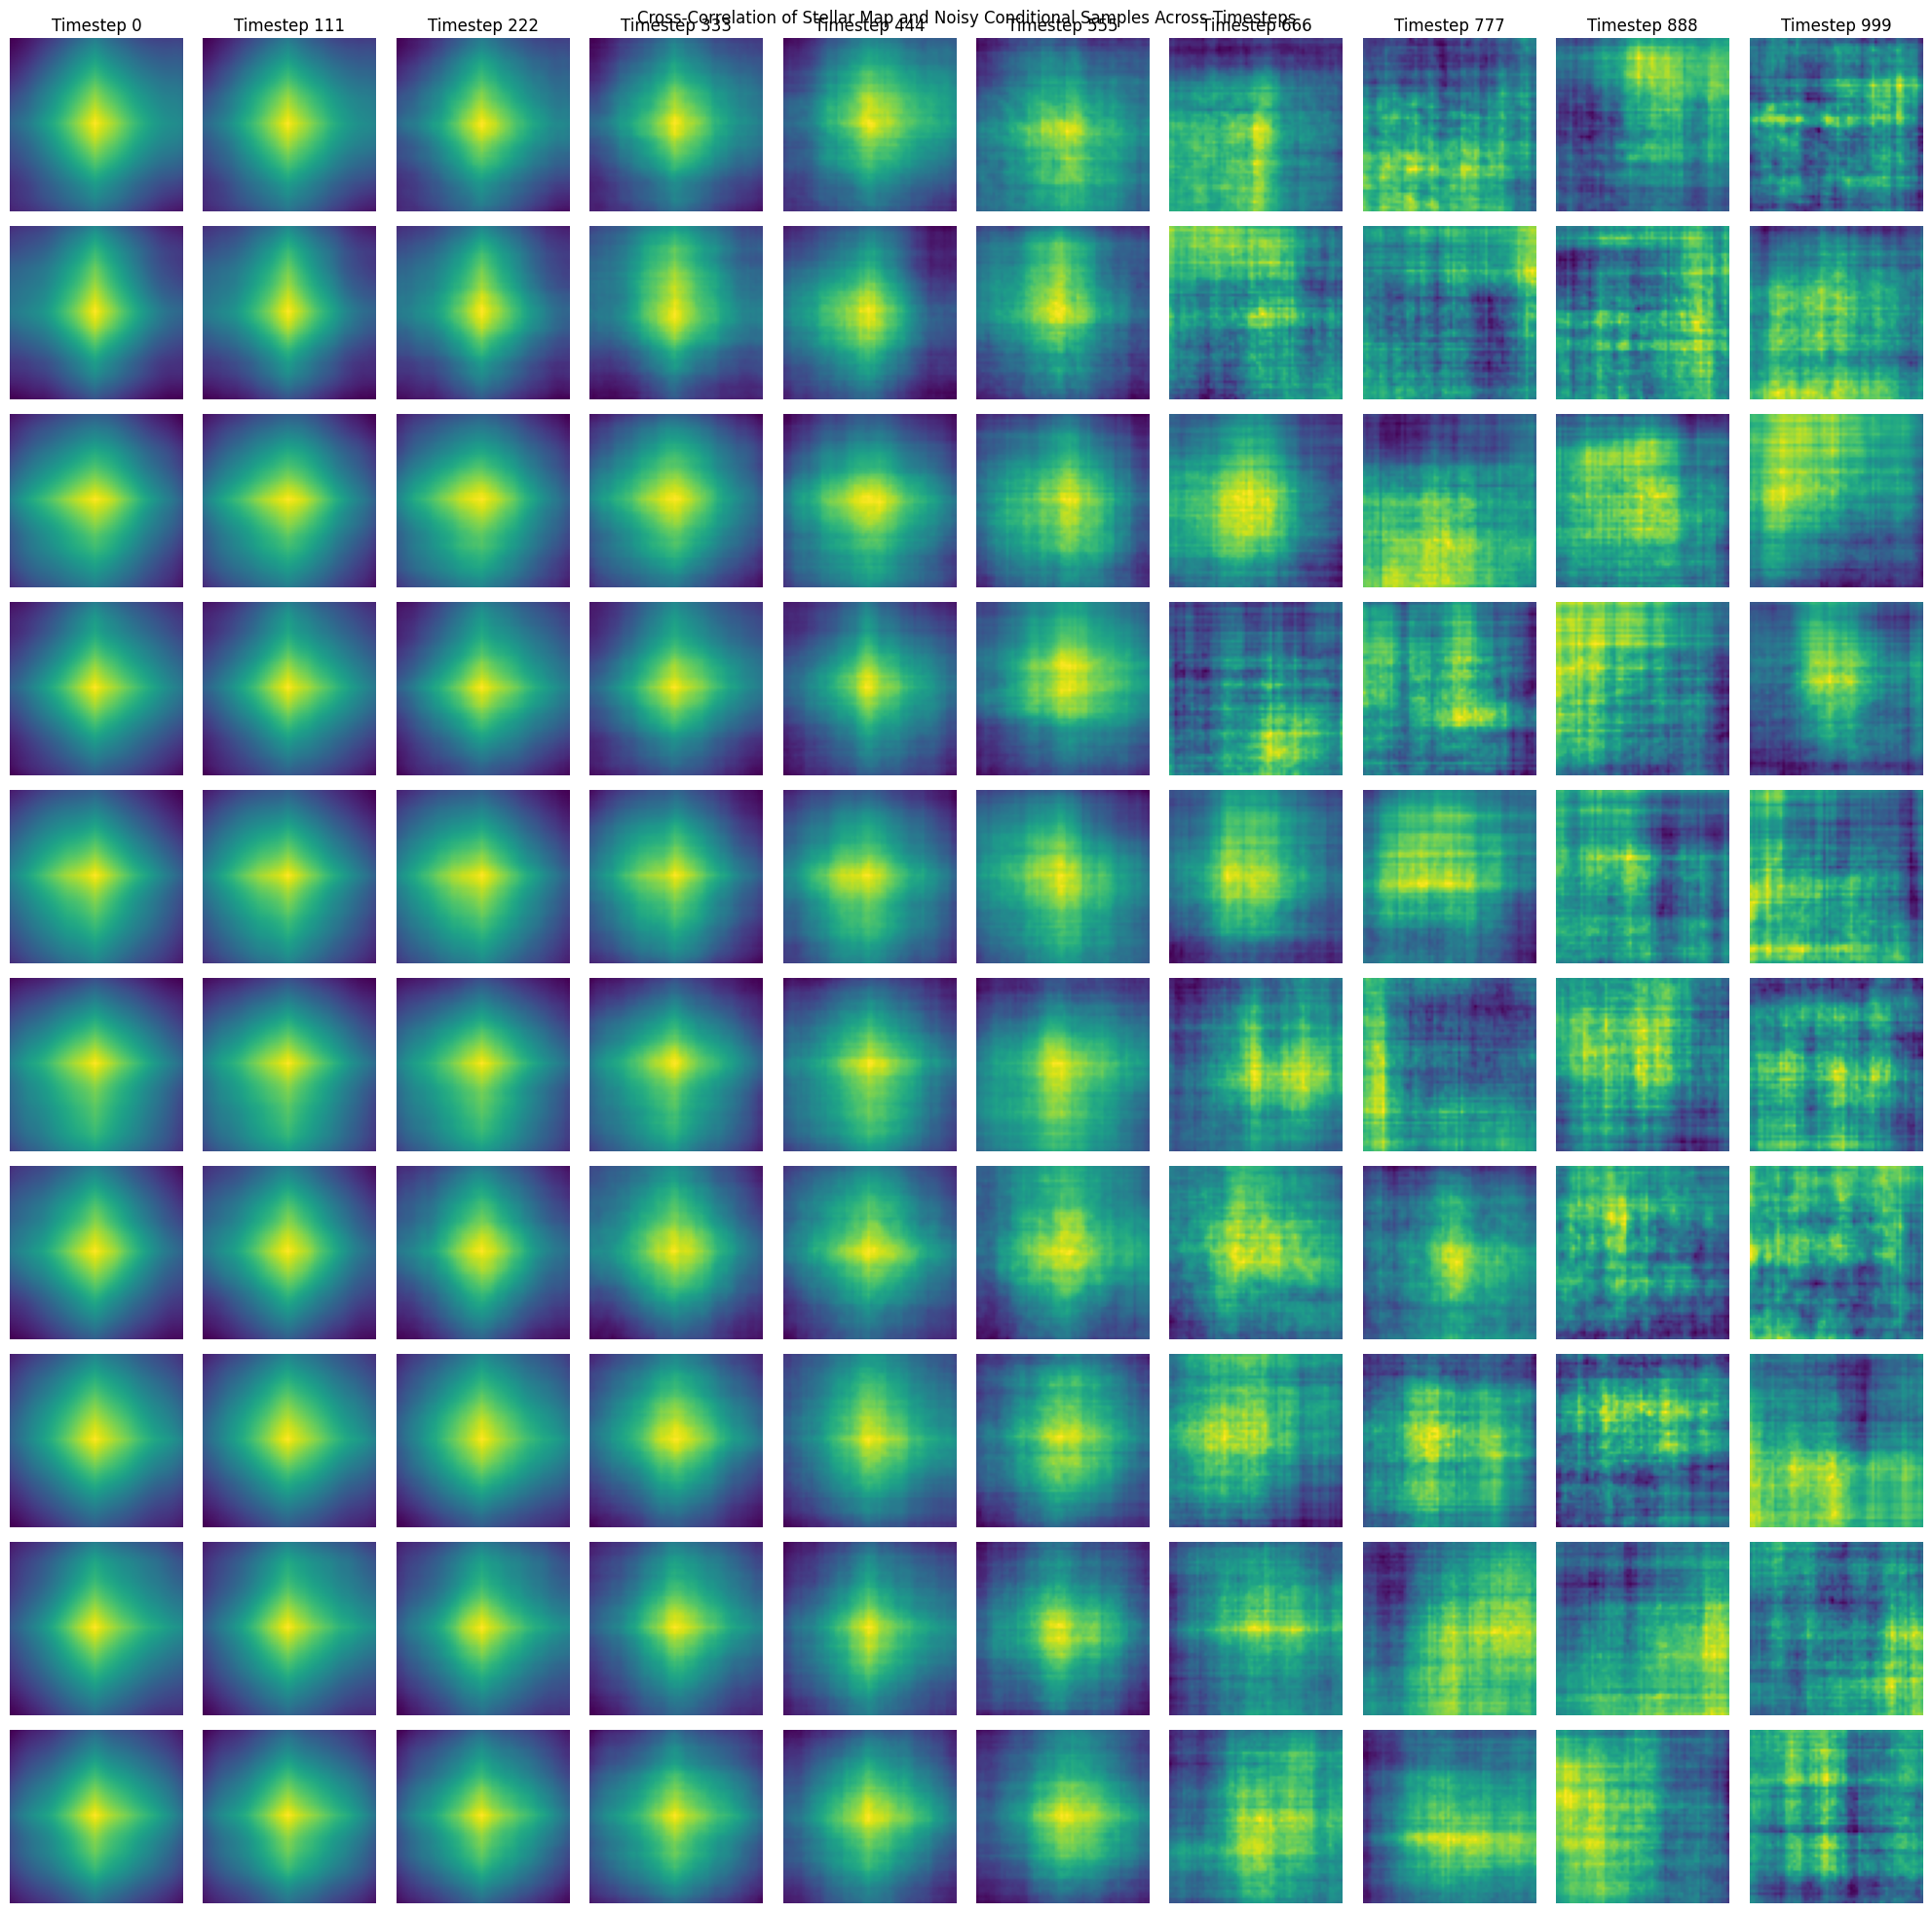

In [ ]:
from scipy.signal import correlate2d

# Function to calculate cross-correlation for 10 samples at 10 timesteps
def calculate_cross_correlation(stellar_maps, dm_maps, model, noise_scheduler):
    cross_corr_results = []

    timesteps = torch.linspace(0, noise_scheduler.num_train_timesteps - 1, 10).long().to(device)

    for i in range(10):
        sample_cross_corr = []
        stellar_map = stellar_maps[i].unsqueeze(0).to(device)
        dm_map = dm_maps[i].unsqueeze(0).to(device)

        for t in timesteps:
            noise = torch.randn_like(dm_map)
            noisy_dm_map = noise_scheduler.add_noise(dm_map, noise, t)

            corr = correlate2d(stellar_map.squeeze().cpu().numpy(), noisy_dm_map.squeeze().cpu().numpy(), mode="same")
            sample_cross_corr.append(corr)

        cross_corr_results.append(sample_cross_corr)

    return cross_corr_results, timesteps.cpu().numpy()

# Visualization of cross-correlation across 10 timesteps for 10 samples
def visualize_cross_corr_timesteps(cross_corr_results, timesteps):
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))

    for i in range(10):
        for j in range(10):
            ax = axes[i, j]
            ax.imshow(cross_corr_results[i][j], cmap="viridis")
            ax.axis("off")
            if i == 0:
                ax.set_title(f"Timestep {timesteps[j]}")
            if j == 0:
                ax.set_ylabel(f"Sample {i+1}")

    plt.suptitle("Cross-Correlation of Stellar Map and Noisy Conditional Samples Across Timesteps")
    plt.tight_layout()
    plt.show()

# Generate and visualize cross-correlation between stellar maps and noisy conditional samples across timesteps
# Get 10 samples from the DataLoader
stellar_maps = next(iter(stellar_dataloader)).to(device)[:10]
dm_maps = next(iter(dm_dataloader)).to(device)[:10]

# Calculate cross-correlation for 10 samples at 10 timesteps
cross_corr_results, timesteps = calculate_cross_correlation(stellar_maps, dm_maps, model, noise_scheduler)

# Visualize the cross-correlation for 10 samples over 10 timesteps
visualize_cross_corr_timesteps(cross_corr_results, timesteps)


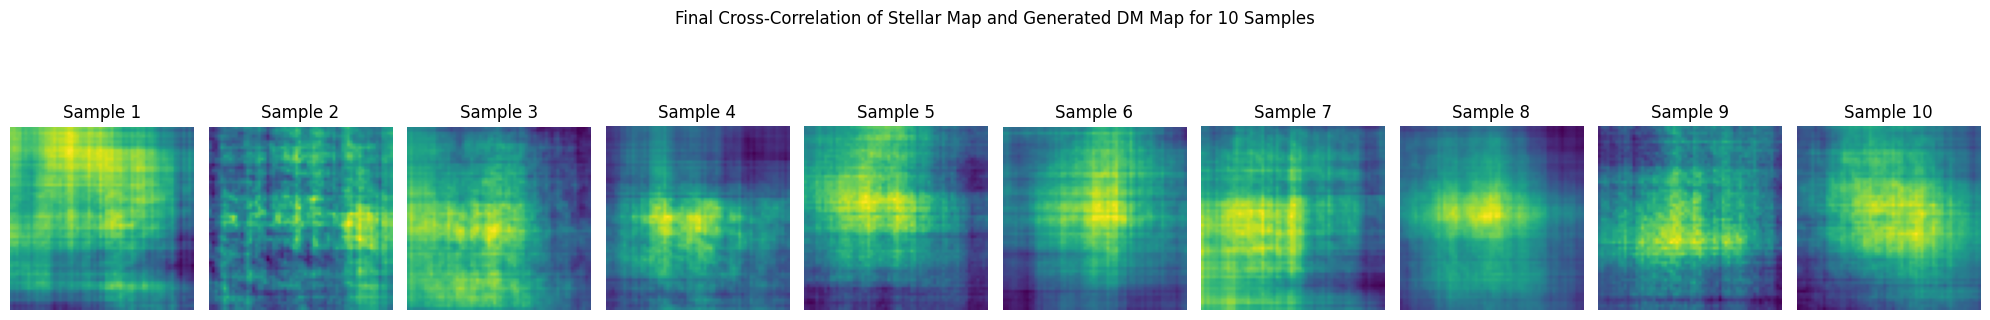

In [ ]:
from scipy.signal import correlate2d

# Sampling loop with cross-correlation calculation for final timestep
def calculate_cross_corr_sequence(model, stellar_maps, noise_scheduler):
    model.eval()
    cross_corr_sequence = []

    with torch.no_grad():
        num_samples = stellar_maps.size(0)
        x = torch.randn((num_samples, 1, config["image_size"], config["image_size"])).to(device)

        for t in range(noise_scheduler.num_train_timesteps):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            residual = model(x, timesteps, stellar_maps)
            x = noise_scheduler.step(residual, t, x).prev_sample

            # Collect cross-correlation only for the final timestep
            if t == noise_scheduler.num_train_timesteps - 1:
                cross_corr_batch = []
                for i in range(10):
                    stellar_map = stellar_maps[i].squeeze().cpu().numpy()
                    final_map = x[i].squeeze().cpu().numpy()
                    corr = correlate2d(stellar_map, final_map, mode="same")
                    cross_corr_batch.append(corr)

                cross_corr_sequence.extend(cross_corr_batch)

    return cross_corr_sequence

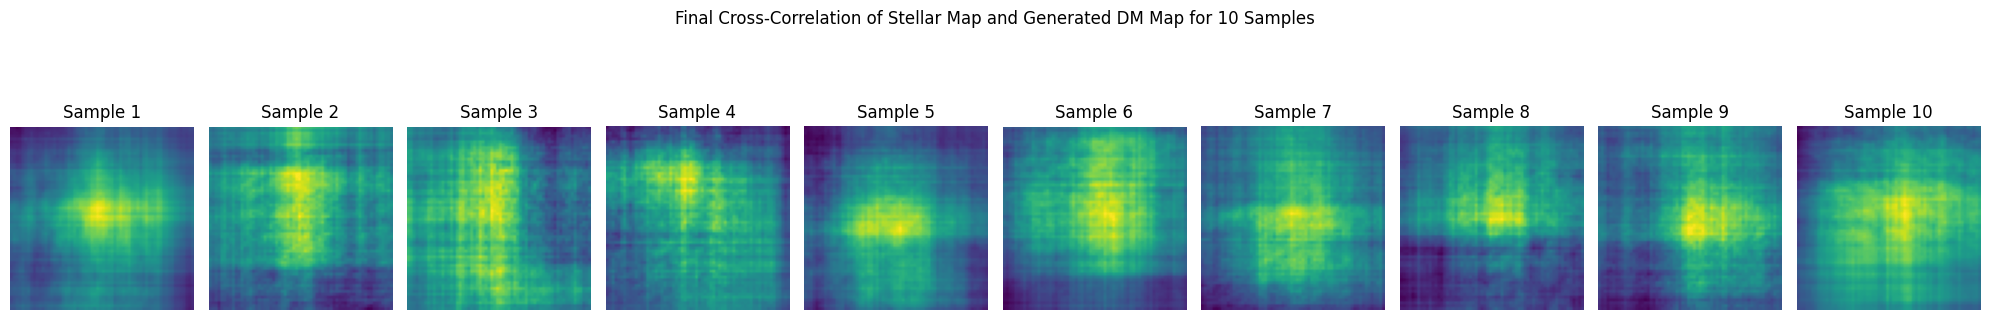

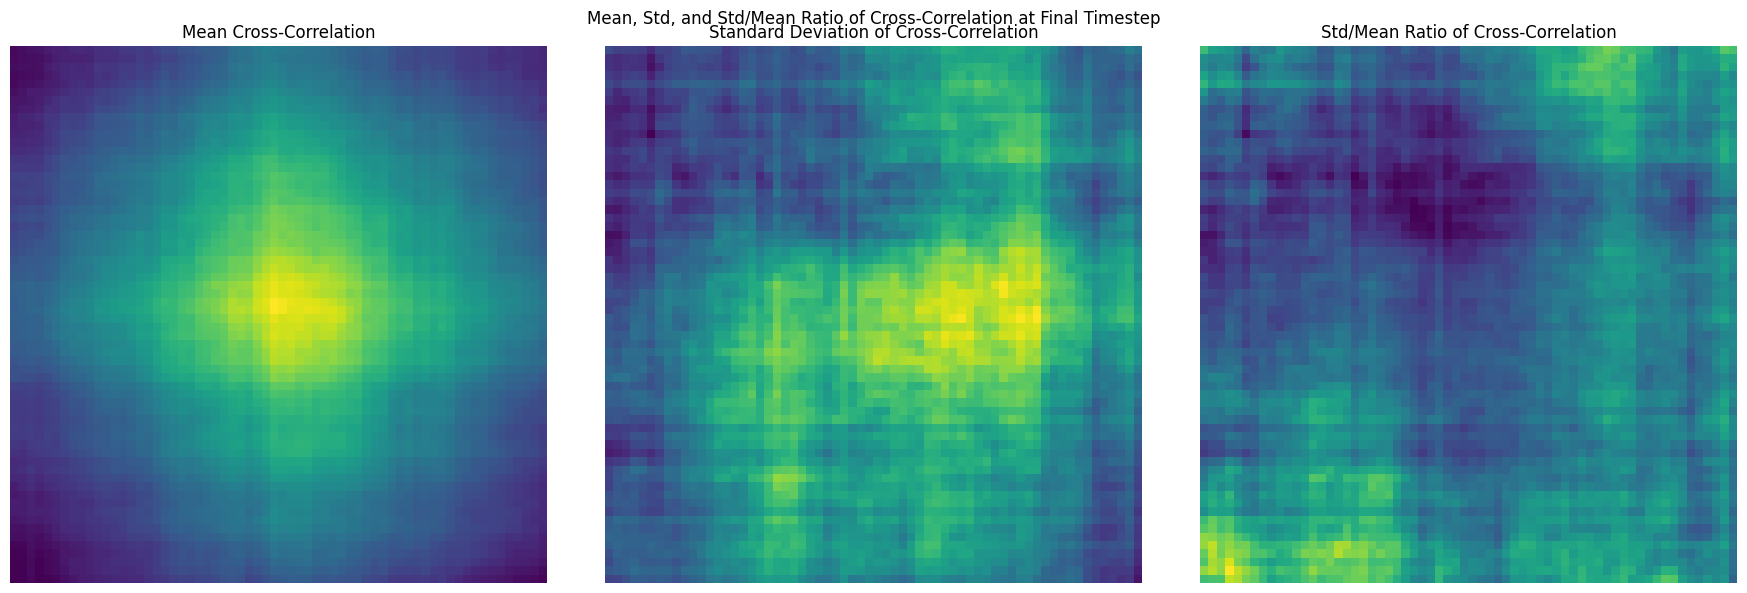

In [ ]:
# Run the cross-correlation sequence generation for the final timestep
sample_stellar_maps = next(iter(stellar_dataloader)).to(device)[:10]  # Use 10 samples from stellar map
cross_corr_sequence = calculate_cross_corr_sequence(model, sample_stellar_maps, noise_scheduler)

# Calculate Mean, Standard Deviation, and Std/Mean Ratio
mean_corr = cross_corr_sequence.mean(axis=0)  # Mean across samples
std_corr = cross_corr_sequence.std(axis=0)    # Standard deviation across samples
ratio_std_mean = np.divide(std_corr, mean_corr, where=mean_corr != 0)  # Avoid division by zero

# Visualization of cross-correlation for 10 samples at the final timestep
fig, axes = plt.subplots(1, len(cross_corr_sequence), figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(cross_corr_sequence[i], cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Sample {i + 1}")

plt.suptitle("Final Cross-Correlation of Stellar Map and Generated DM Map for 10 Samples")
plt.tight_layout()
plt.show()

# Visualization of Mean, Std, and Std/Mean Ratio
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Mean Cross-Correlation
axes[0].imshow(mean_corr, cmap="viridis")
axes[0].set_title("Mean Cross-Correlation")
axes[0].axis("off")

# Standard Deviation of Cross-Correlation
axes[1].imshow(std_corr, cmap="viridis")
axes[1].set_title("Standard Deviation of Cross-Correlation")
axes[1].axis("off")

# Std/Mean Ratio of Cross-Correlation
axes[2].imshow(ratio_std_mean, cmap="viridis")
axes[2].set_title("Std/Mean Ratio of Cross-Correlation")
axes[2].axis("off")

plt.suptitle("Mean, Std, and Std/Mean Ratio of Cross-Correlation at Final Timestep")
plt.tight_layout()
plt.show()
